<a href="https://colab.research.google.com/github/mobinapourmoshir/Functional-Deep-Learning/blob/main/Iris_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Building a multilayer perceptron for classifying flowers in the Iris dataset**

In [1]:
# Loadeing Iris data
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris['data']
y = iris['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1./3, random_state=1)

In [2]:
import torch
import numpy as np
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
# Standardizing the data
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train)
# Data set
train_ds = TensorDataset(X_train_norm, y_train)
# Data loader
torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [3]:
import torch.nn as nn
# Defining class of the model
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)  # Layer 1
        self.layer2 = nn.Linear(hidden_size, output_size) # Layer 2

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x)
        return x

input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3

model = Model(input_size, hidden_size, output_size)

learning_rate = 0.001
# Defining Loss function
loss_fn = nn.CrossEntropyLoss()
# Defining Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [4]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()

    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

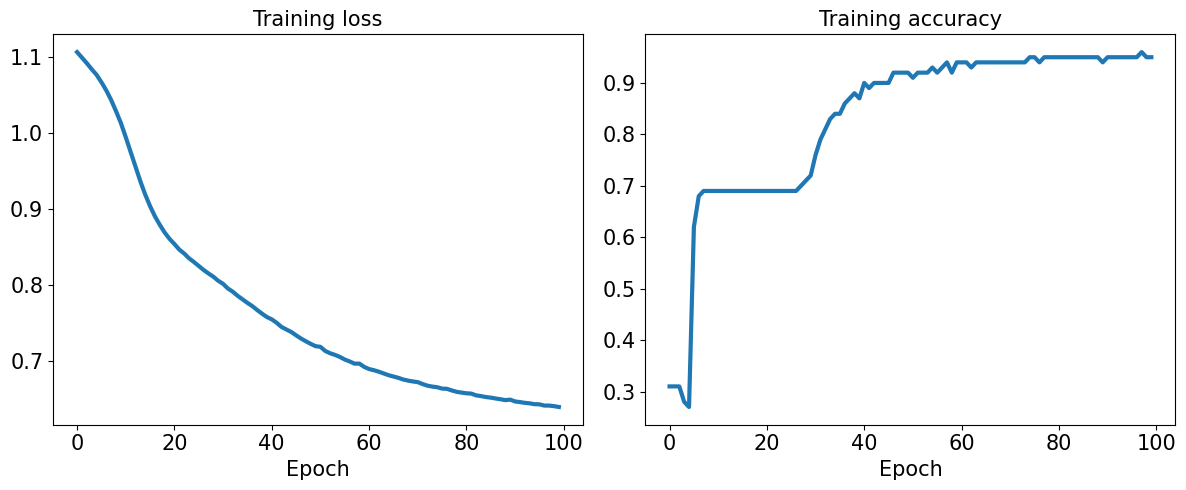

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

#plt.savefig('figures/12_09.pdf')

plt.show()

### **Evaluating the trained model on the test dataset**

In [6]:
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test)
pred_test = model(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()

print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800


### **Saving and reloading the trained model**

In [7]:
#path = 'iris_classifier.pt'
#torch.save(model, path)
#model_new = torch.load(path)
#model_new.eval()

### **Confusion matrix**

[[17  0  0]
 [ 0 18  1]
 [ 0  0 14]]


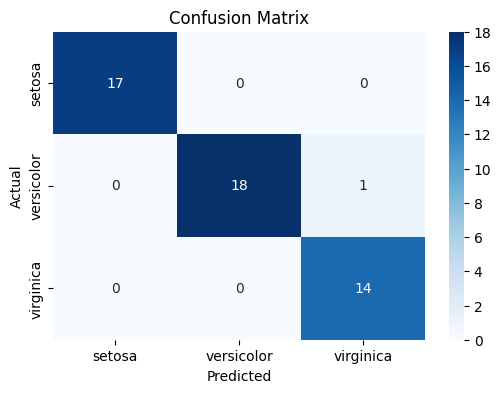

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = torch.argmax(pred_test, dim=1) # Get predicted class labels
# Convert tensors to NumPy arrays
y_true_np = y_test.numpy()
y_pred_np = y_pred.numpy()

# Compute the confusion matrix
cm = confusion_matrix(y_true_np, y_pred_np)
print(cm)

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['setosa', 'versicolor', 'virginica'],
            yticklabels=['setosa', 'versicolor', 'virginica'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### **Accuracy and loss on both train and validation data (Training Plot)**

Epoch 01 | train_acc=0.970 | val_acc=0.980
Epoch 02 | train_acc=0.970 | val_acc=0.980
Epoch 03 | train_acc=0.970 | val_acc=0.980
Epoch 04 | train_acc=0.970 | val_acc=0.980
Epoch 05 | train_acc=0.970 | val_acc=0.980
Epoch 06 | train_acc=0.970 | val_acc=0.980
Epoch 07 | train_acc=0.970 | val_acc=0.980
Epoch 08 | train_acc=0.970 | val_acc=0.980
Epoch 09 | train_acc=0.970 | val_acc=0.980
Epoch 10 | train_acc=0.970 | val_acc=0.980
Epoch 11 | train_acc=0.970 | val_acc=0.980
Epoch 12 | train_acc=0.970 | val_acc=0.980
Epoch 13 | train_acc=0.970 | val_acc=0.980
Epoch 14 | train_acc=0.970 | val_acc=0.980
Epoch 15 | train_acc=0.970 | val_acc=0.980
Epoch 16 | train_acc=0.970 | val_acc=0.980
Epoch 17 | train_acc=0.970 | val_acc=0.980
Epoch 18 | train_acc=0.970 | val_acc=0.980
Epoch 19 | train_acc=0.970 | val_acc=0.980
Epoch 20 | train_acc=0.970 | val_acc=0.980
Epoch 21 | train_acc=0.970 | val_acc=0.980
Epoch 22 | train_acc=0.970 | val_acc=0.980
Epoch 23 | train_acc=0.970 | val_acc=0.980
Epoch 24 | 

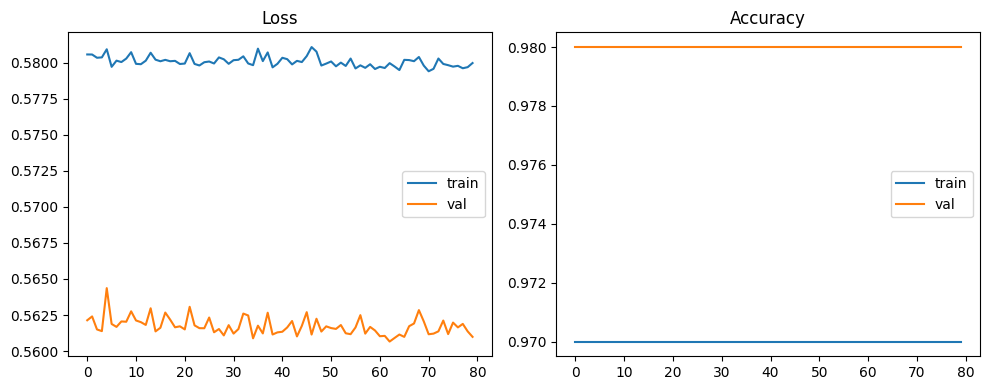

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare validation loader
valid_ds = TensorDataset(X_test_norm.float(), y_test.long())
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

# Define loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
def train(model, num_epochs, train_dl, valid_dl):
    tr_loss, va_loss, tr_acc, va_acc = [], [], [], []

    for epoch in range(num_epochs):
        # Training the model
        model.train()
        tl, tc, n = 0.0, 0, 0
        for x_batch, y_batch in train_dl:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            pred = model(x_batch)              # (1) forward pass
            loss = loss_fn(pred, y_batch)      # (2) loss
            loss.backward()                    # (3) backward
            optimizer.step()                   # (4) update
            optimizer.zero_grad()              # (5) reset gradients

            # training loss & accuracy
            tl += loss.item() * y_batch.size(0)
            preds = torch.argmax(pred, dim=1)
            tc += (preds == y_batch).sum().item()
            n  += y_batch.size(0)

        tr_loss.append(tl / n)
        tr_acc.append(tc / n)

        # Validation
        model.eval()
        vl, vc, n = 0.0, 0, 0
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                logits = model(x_batch)
                loss = loss_fn(logits, y_batch)
                vl += loss.item() * y_batch.size(0)
                preds = torch.argmax(logits, dim=1)
                vc += (preds == y_batch).sum().item()
                n  += y_batch.size(0)

        va_loss.append(vl / n)
        va_acc.append(vc / n)

        print(f"Epoch {epoch+1:02d} | train_acc={tr_acc[-1]:.3f} | val_acc={va_acc[-1]:.3f}")

    return tr_loss, va_loss, tr_acc, va_acc

# Run Training
num_epochs = 80
tr_loss, va_loss, tr_acc, va_acc = train(model, num_epochs, train_dl, valid_dl)

# Plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(tr_loss, label="train"); plt.plot(va_loss, label="val"); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(tr_acc, label="train"); plt.plot(va_acc, label="val"); plt.title("Accuracy"); plt.legend()
plt.tight_layout(); plt.show()
